In [1]:
import numpy as np
import matplotlib.pyplot as plt

from landlab import RasterModelGrid
from landlab.plot import imshow_grid

## Algorithm description

The conservation of mass for an isothermal, shallow, non-sliding ice mass states:
$$
\frac{\partial H}{\partial t} = \dot{m} + \nabla\cdot\left[\Gamma H^{n + 2}|\nabla s|^{n - 1}\nabla s\right],
$$
where $H$ is the thickness of the ice mass, $\dot{m}$ is the specific mass balance, $n$ is Glen's flow law exponent, and $s$ is the ice surface slope, such that $H = s - b$ for some bed elevation $b$. The coefficient $\Gamma$ is given by:
$$
\Gamma = \frac{2A(\rho g)^n}{n + 2}. 
$$

In [7]:
class ShallowIce:
    '''This class implements a numerical solution to the shallow ice approximation.

    Attributes:
        Nx: integer - number of grid cells in the x-direction
        Ny: integer - number of grid cells in the y-direction
        dx: float - grid spacing in the x-direction
        dy: float - grid spacing in the y-direction

    Initialization:
        ice_thickness: 2D array of floats - the initial ice thickness field
        bed_elevation: 2D array of floats - the elevation of the bedrock surface
        mass_balance: 2D array of floats - the mass balance in each grid cell
    '''

    glens_n = 3
    glens_coeff = 3e-24
    ice_density = 917 # kg m^-3
    gravity = 9.81 # m s^-2

    def __init__(self, Nx: int, Ny: int, dx: float, dy: float):
        '''Initialize the model with grid cell counts and spacing in each direction.'''

        # Set up the grid
        self.grid = RasterModelGrid((Nx, Ny), (dx, dy))
        self.Nx = Nx
        self.Ny = Ny
        self.dx = dx
        self.dy = dy
        
        # Initialize empty fields
        self.grid.add_empty('ice_thickness', at = 'node')
        self.grid.add_empty('bed_elevation', at = 'node')
        self.grid.add_empty('ice_surface', at = 'node')
        self.grid.add_empty('mass_balance', at = 'node')
        self.grid.add_empty('ice_flux', at = 'link')

        # Set initial conditons
        self.calc_fluidity()

        # Simulation variables
        self.time_elapsed = 0.0 # seconds
        self.time_step = 0.0 # seconds

    def calc_fluidity(self):
        '''Calculate the fluidity of the ice.'''
        self.fluidity = (2 * self.glens_coeff * (self.ice_density * self.gravity)**self.glens_n) / (self.glens_n + 2)

    def update_surface(self):
        '''Ensure that the ice thickness is non-negative, then updates the ice surface elevation.'''

        # Ensure the ice thickness is non-negative everywhere
        self.grid.at_node['ice_thickness'][:] = np.where(self.grid.at_node['ice_thickness'][:] >= 0, self.grid.at_node['ice_thickness'][:], 0.0)

        # Update the ice surface elevation
        self.grid.at_node['ice_surface'][:] = self.grid.at_node['ice_thickness'][:] - self.grid.at_node['bed_elevation'][:]

    def calc_time_step(self, CFL: float):
        '''Estimate the stable time step from a CFL condition.'''
        self.calc_flux()
        self.divergence = self.grid.calc_flux_div_at_node('ice_flux')

        self.time_step = (CFL * self.dx * self.dy) / np.max(self.divergence[:])

    def calc_flux(self):
        '''Calculate the ice flux at links between each grid cell.'''

        # Compute the gradient of the ice surface at links
        gradient_links = self.grid.calc_grad_at_link('ice_surface')

        # Map ice thickness onto links
        thickness_links = self.grid.map_mean_of_link_nodes_to_link('ice_thickness')**5

        # Compute the ice flux
        diffusivity = self.fluidity * thickness_links * np.abs(gradient_links)**(self.glens_n - 1)
        self.grid.at_link['ice_flux'] = diffusivity * gradient_links

    def run_one_euler(self, dt: float):
        '''Run one time step of length dt, using a forward Euler algorithm.'''

        # Calculate the ice flux
        self.calc_flux()

        # Compute the divergence of ice flux
        self.divergence = self.grid.calc_flux_div_at_node('ice_flux')

        # New ice thickness = old ice thickness + time derivative of ice thickness * dt
        self.change_in_thickness = self.grid.at_node['mass_balance'] + self.divergence
        self.grid.at_node['ice_thickness'][:] += self.change_in_thickness * dt

        # Update the ice surface elevation and time elapsed
        self.update_surface()
        self.time_elapsed += dt

    def calc_flux_midpont(self, midpoint_thickness):
        '''Calculate the ice flux given a new ice thickness, e.g., during the RK4 algorithm.'''

        # Ensure the thickness is non-negative everywhere
        midpoint_thickness = np.where(midpoint_thickness >= 0, midpoint_thickness, 0.0)

        # Map the new thickness onto links
        midpoint_thickness_links = self.grid.map_mean_of_link_nodes_to_link(midpoint_thickness)**5

        # Update the surface elevation and gradient
        midpoint_surface = midpoint_thickness - self.grid.at_node['bed_elevation'][:]
        midpoint_gradient = self.grid.calc_grad_at_link(midpoint_surface)

        # Compute the ice flux and divergence
        midpoint_diffusivity = self.fluidity * midpoint_thickness_links * np.abs(midpoint_gradient)**(self.glens_n - 1)
        midpoint_ice_flux = midpoint_diffusivity * midpoint_gradient
        midpoint_divergence = self.grid.calc_flux_div_at_node(midpoint_ice_flux)

        return midpoint_divergence

    def run_one_rk4(self, dt: float, updated_mass_balance = None):
        '''Run one time step of length dt, using a fourth-order Runge-Kutta algorithm.'''

        # Calculate the divergence of ice flux at the beginning of the time step
        self.calc_flux()
        self.divergence = self.grid.calc_flux_div_at_node('ice_flux')

        # Interpolate the mass balance at the midpoint
        if updated_mass_balance != None:
            startpoint_mass_balance = self.grid.at_node['mass_balance'][:].copy()
            endpoint_mass_balance = updated_mass_balance[:].copy()
            midpoint_mass_balance = (startpoint_mass_balance - endpoint_mass_balance) / 2
        else:
            startpoint_mass_balance = self.grid.at_node['mass_balance'][:].copy()
            endpoint_mass_balance = self.grid.at_node['mass_balance'][:].copy()
            midpoint_mass_balance = self.grid.at_node['mass_balance'][:].copy()

        # Calculate the time derivative of ice thickness at the beginning of the time step
        k1 = self.grid.at_node['mass_balance'] + self.divergence

        # Calculate the time derivative of ice thickness at the midpoint, using k1
        ice_thickness_k2 = self.grid.at_node['ice_thickness'][:].copy() + (k1 * dt / 2)
        k2 = midpoint_mass_balance + self.calc_flux_midpont(ice_thickness_k2)

        # Calculate the time derivative of ice thickness at the midpoint, using k2
        ice_thickness_k3 = self.grid.at_node['ice_thickness'][:].copy() + (k2 * dt / 2)
        k3 = midpoint_mass_balance + self.calc_flux_midpont(ice_thickness_k3)

        # Calculate the time derivative of ice thickness at the endpoint of the time step
        ice_thickness_k4 = self.grid.at_node['ice_thickness'][:].copy() + (k3 * dt)
        k4 = endpoint_mass_balance + self.calc_flux_midpont(ice_thickness_k4)

        # Use a weighted sum of k1-k4 to estimate the new ice thickness
        self.grid.at_node['ice_thickness'] += dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6
        self.update_surface()
        self.time_elapsed += dt

## Test suite

The test suite follows the experiments outlined by Bueler and others: 

Bueler, E., Lingle, C. S., Kallen-Brown, J. A., Covey, D. N., & Bowman, L. N. (2005). Exact solutions and verification of numerical models for isothermal ice sheets. Journal of Glaciology, 51(173), 291-306.

### A) Steady-state, constant accumulation

In [8]:
def fracpower(q, p):
    return np.abs(q)**p * np.sign(q)

In [63]:
sec_per_a = 3.14e7
M0 = 0.3 * (1 / sec_per_a) # m a^-1
L = 750e3

Nx = 100
Ny = 100
dx = 10000
dy = 10000

sia = ShallowIce(Nx, Ny, dx, dy)
sia.calc_fluidity()

origin = [0, 0]
radius = np.sqrt((sia.grid.node_x - origin[0])**2 + (sia.grid.node_y - origin[1])**2)

initial_height = (2**2 * M0 / sia.fluidity)**(1 / 8) * fracpower(L**(4/3) - radius**(4/3), 3 / 8)
sia.grid.at_node['ice_thickness'][:] = initial_height
sia.grid.at_node['bed_elevation'][:] = 0.0
sia.grid.at_node['mass_balance'][:] = M0
sia.update_surface()

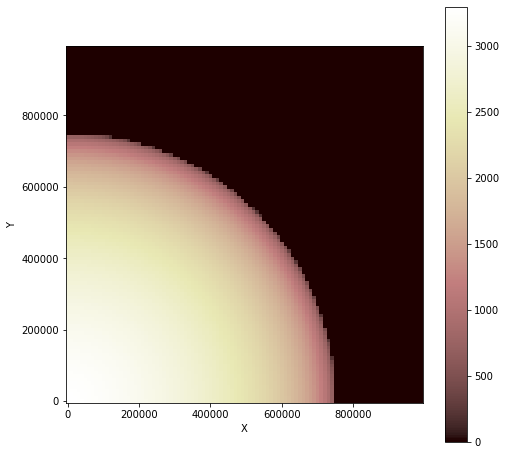

In [64]:
fig, ax = plt.subplots(figsize = (8, 8))
imshow_grid(sia.grid, 'ice_thickness')

In [65]:
profiles = []
profiles.append(np.diagonal(sia.grid.node_vector_to_raster(sia.grid.at_node['ice_surface']))[int(sia.Nx / 4):])

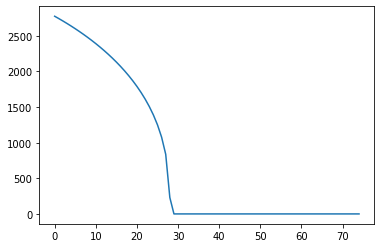

In [66]:
plt.plot(profiles[0])
plt.show()

In [68]:
final_t = 25000 # years
count = 0
dt = 60 * 60 * 24 * 30

profiles = []

while (sia.time_elapsed * 3.14e-8) < final_t:
    
    sia.run_one_rk4(dt)
    
    profiles.append(np.diagonal(sia.grid.node_vector_to_raster(sia.grid.at_node['ice_surface']))[int(sia.Nx / 4):])
    
    if count % 100 == 0:
        print('Completed ' + str(count) + ' time steps.')
    count += 1
    
print('Time elapsed: ' + str(sia.time_elapsed * 3.14e-8) + ' years.')

Completed 0 time steps.
Completed 100 time steps.
Completed 200 time steps.
Completed 300 time steps.
Completed 400 time steps.
Completed 500 time steps.


KeyboardInterrupt: 

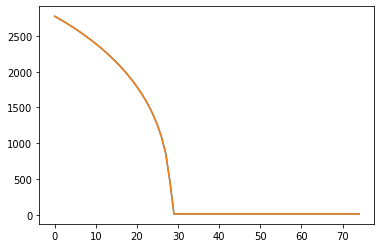

In [69]:
plt.plot(profiles[0])
plt.plot(profiles[-1])
plt.show()

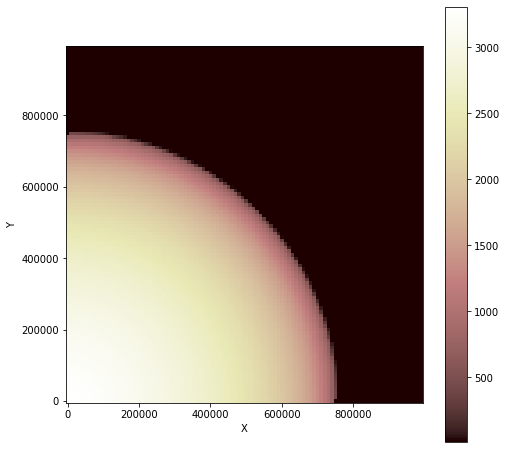

In [70]:
fig, ax = plt.subplots(figsize = (8, 8))
imshow_grid(sia.grid, 'ice_thickness')

### B) Similarity solution with moving margin and zero accumulation

### C) Similarity solution with no initial ice thickness

### D) Oscillating accumulation

### E) Steady-state with linear basal sliding